# Sentiment Analysis

Congrats, you finished the part on the data preparation, and we can now move on to the more exciting part of using RNNs/LSTMs to process sequential data! But be careful, even if the previous notebook might seem a little bit boring, it is of great importance. We switched from images to text data in this exercise, and remember the first steps that we did in our class were also data related, and they were essential for all the following exercises. So naturally, since we switched to text data in this exercise, make sure you have a good understanding of how the data has been prepared.

For the last I2DL exercise, we want to make use of Recurrent Neural Networks (RNNs) to process sequential data. We will stick with the same dataset we have been looking at in the previous notebook, namely the [IMDb](https://ai.stanford.edu/~amaas/data/sentiment/) sentiment analysis dataset that contains positive and negative movie reviews.

<p class="aligncenter">
    <img src="images/IMDB.jpg" alt="centered image" />
</p>

Sentiment analysis is the task of predicting the sentiment of a text. In this notebook, you will train a network to process reviews from the dataset and evaluate whether it has been a positive or a negative review. Below are two examples:

<p class="aligncenter">
    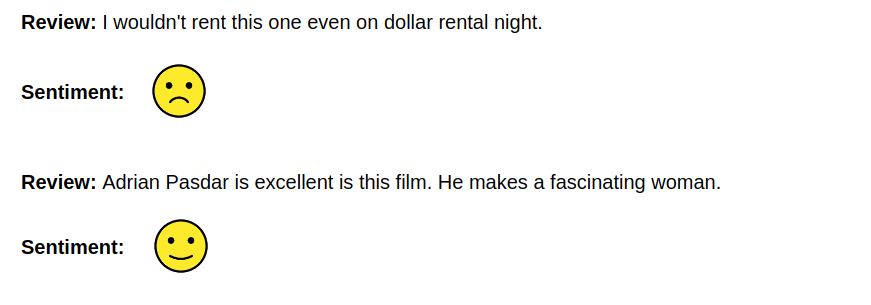
</p>


## (Optional) Mount folder in Colab

Uncomment the following cell to mount your gdrive if you are using the notebook in google colab:

In [ ]:
# Use the following lines if you want to use Google Colab
# We presume you created a folder "i2dl" within your main drive folder, and put the exercise there.
# NOTE: terminate all other colab sessions that use GPU!
# NOTE 2: Make sure the correct exercise folder (e.g exercise_11) is given.

"""
from google.colab import drive
import os

gdrive_path='/content/gdrive/MyDrive/i2dl/exercise_11'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))
"""

### Set up PyTorch environment in colab
- (OPTIONAL) Enable GPU via Runtime --> Change runtime type --> GPU
- Uncomment the following cell if you are using the notebook in google colab:

In [ ]:
# Optional: install correct libraries in google colab
# !python -m pip install torch==1.11.0+cu113 torchvision==0.12.0+cu113 -f https://download.pytorch.org/whl/torch_stable.html
# !python -m pip install tensorboard==2.8.0
# !python -m pip install pytorch-lightning==1.6.0

# 0. Setup

As always, we first import some packages to setup the notebook.

In [ ]:
import os
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_

from exercise_code.rnn.sentiment_dataset import (
    download_data,
    load_sentiment_data,
    load_vocab,
    SentimentDataset,
    collate
)

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# 1. Loading Data

As we have learned from the notebook 1, this time we not only load the raw data, but also have the corresponding vocabulary. Let us load the data that we prepared for you:

In [ ]:
i2dl_exercises_path = os.path.dirname(os.path.abspath(os.getcwd()))
data_root = os.path.join(i2dl_exercises_path, "datasets", "SentimentData")
base_dir = download_data(data_root)
vocab = load_vocab(base_dir)
train_data, val_data, test_data = load_sentiment_data(base_dir, vocab)

print("number of training samples: {}".format(len(train_data)))
print("number of validation samples: {}".format(len(val_data)))
print("number of test samples: {}".format(len(test_data)))

## Dataset Samples

Our raw data consists of tuples `(raw_text, token_list, token_indices, label)`. Let's sample some relatively short texts from our dataset to have a sense how it looks like:

In [ ]:
sample_data0 = [datum for datum in train_data if len(datum[1]) < 20 and datum[-1] == 0] # negative
sample_data1 = [datum for datum in train_data if len(datum[1]) < 20 and datum[-1] == 1] # positive

# we sample 2 tuples each from positive set and negative set
sample_data = random.sample(sample_data0, 2) + random.sample(sample_data1, 2)
for text, tokens, indices, label in sample_data:
    print('Text: \n {}\n'.format(text))
    print('Tokens: \n {}\n'.format(tokens))
    print('Indices: \n {}\n'.format(indices))
    print('Label:\n {}\n'.format(label))
    print()

## Checking the Vocabulary

In the previous notebook, we discussed the need of a vocabulary for mapping words to unique integer IDs. Instead of creating the vocabulary manually, we provide you with the vocabulary. Let's have a look at some samples from the vocabulary of the dataset:

In [ ]:
print('Vocabulary size:', len(vocab), '\n\n  Sample words\n{}'.format('-' * 20))
sample_words = random.sample(list(vocab.keys()), 10)
for word in sample_words:
    print(' {}'.format(word))

Also we saw that there are already indices in the raw data that we loaded. We can check if the indices in the vocabulary match the raw data using the last sentence in `sample_data`. Words that are not in the vocabulary are assigned to the symbol `<unk>`. The output of the following cell should be the same as the indices in the last example of our loaded raw data:

In [ ]:
# Last sample from above 
(text, tokens, indices, label) = sample_data[-1]
print('Text: \n {}\n'.format(text))
print('Tokens: \n {}\n'.format(tokens))
print('Indices: \n {}\n'.format(indices))
print('Label:\n {}\n'.format(label))

# Compare with the vocabulary
print('Indices drawn from vocabulary: \n {}\n'.format([vocab.get(x, vocab['<unk>']) for x in sample_data[-1][1]]))

## Wrapping to PyTorch Datasets

Great, the raw data is loaded properly and the vocabulary is matching. Let us wrap our data in a PyTorch dataset. For more details, check out the previous notebook and the corresponding dataset class defined in `exercise_code/rnn/sentiment_dataset.py`.

In [ ]:
# Define a Dataset Class for train, val and test set
train_dataset = SentimentDataset(train_data)
val_dataset = SentimentDataset(val_data)
test_dataset = SentimentDataset(test_data)

# 2. Creating a Sentiment Classifier

After we have loaded the data, it is time to define a model and start training and testing.

## Evaluation Metrics

Since we just need to predict positive or negative, we can use `binary cross-entropy loss` to train our model. And accuracy can be used to assess our model's performance. We will use the following evaluation model to compute the accuracy.

In [ ]:
bce_loss = nn.BCELoss()

@torch.no_grad()
def compute_accuracy(model, data_loader):
    corrects = 0
    total = 0
    device = next(model.parameters()).device
    
    for i, x in enumerate(data_loader):
        input = x['data'].to(device)
        lengths = x['lengths']
        label = x['label'].to(device)
        pred = model(input, lengths)
        corrects += ((pred > 0.5) == label).sum().item()
        total += label.numel()
        
        if i > 0  and i % 100 == 0:
            print('Step {} / {}'.format(i, len(data_loader)))
    
    return corrects / total

## Step 1: Design your own model

In this part, you need to create a classifier using the Embedding layers you implemented in the first notebook and LSTM. For the LSTM, you may also use the PyTorch implementation.

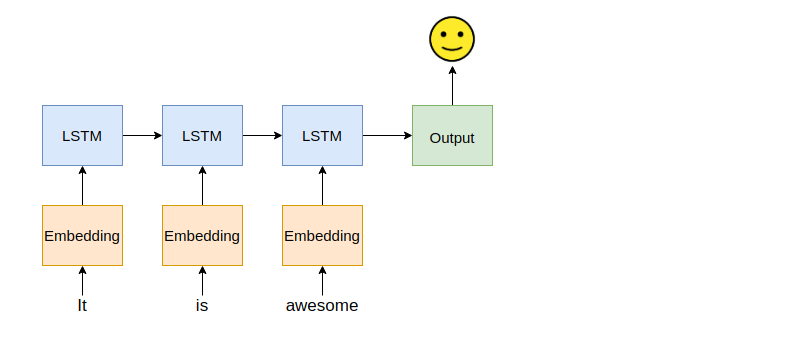



<div class="alert alert-info">
    <h3>Task: Implement a Classifier</h3>
    
   Go to <code>exercise_code/rnn/text_classifiers.py</code> and implement the <code>RNNClassifier</code>. In the skeleton code, we inherited <code>nn.Module</code>. You can also inherit <code>LightningModule</code> if you want to use PyTorch Lightning.
</div>

This file is mostly empty but contains the expected class name, and the methods that your model needs to implement (only `forward()` basically). 
The only rules your model design has to follow are:
* Inherit from `torch.nn.Module` or `pytorch_lightning.LightningModule`
* Perform the forward pass in `forward()`.
* Have less than 2 million parameters
* Have a model size of less than 50MB after saving

After you finished, edit the below cell to make sure your implementation is correct. You should define the model yourself, which should be small enough (2 Mio. parameters) and have correct output format.

In [ ]:
from exercise_code.rnn.tests import classifier_test, parameter_test
from exercise_code.rnn.text_classifiers import RNNClassifier

model = None

########################################################################
# TODO - Create a Model                                               #
########################################################################

pass

########################################################################
#                           END OF YOUR CODE                           #
########################################################################

# Check whether your model is sufficiently small and have a correct output format
parameter_test(model), classifier_test(model, len(vocab))

## Step 2: Train your own model

In this section, you need to train the classifier you created. Below, you can see some setup code we provided to you. Note the **collate function** used with the `DataLoader`. If you forgot why we need the collate function here, check this out in Notebook 1.

You are free to change the below configs (e.g. batch size, device setting etc.) as you wish.

In [ ]:
# Training configs
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('Using {}...\n'.format(device))

# Move model to the device we are using
model = model.to(device)

# To tackle with the exploding gradient problem, you may want to set gclip and use clip_grad_norm_
# see the optional notebook for the explanation
gclip = None

# Dataloaders, note the collate function
train_loader = DataLoader(
  train_dataset, batch_size=16, collate_fn=collate, drop_last=True
)
val_loader = DataLoader(
  val_dataset, batch_size=16, collate_fn=collate, drop_last=False
)

<div class="alert alert-info">
<h3>Task: Implement Training</h3>
    <p>
        In the below cell, you are expected to implement your training loop to train your model. You can use the training loader provided above for iterating over the data. If you want to evaluate your model periodically, you may use the validation loader provided above. You can use pure PyTorch or PyTorch Lightning.
   </p>
</div>

**Hints :**
* Use `torch.nn.BCELoss` as loss function
* Revise the previous exercises if you get stuck.


In [ ]:
########################################################################
#                     TODO - Train Your Model                          #
########################################################################


pass

########################################################################
#                           END OF YOUR CODE                           #
########################################################################

## Testing the Model

As you trained a model and improved it on the validation set, you can now test it on the test set.

In [ ]:
test_loader = DataLoader(
  test_dataset, batch_size=8, collate_fn=collate, drop_last=False
)

print("accuracy on test set: {}".format(compute_accuracy(model, test_loader)))

## Demo


Now that you trained a sufficiently good sentiment classifier, run the below cell and type some text to see some predictions (type exit to quit the demo). Since we used a small data, don't expect too much :).
<div class="alert alert-warning">
<h3>Warning!</h3>
    <p>
        As there is a while True loop in the cell below, you can skip this one for now and run the cell under '3. Submission' first to save your model. 
   </p>
</div>

In [ ]:
from exercise_code.rnn.sentiment_dataset import tokenize

text = ''
w2i = vocab
while True:
    text = input()
    if text == 'exit':
        break

    words = torch.tensor([
        w2i.get(word, w2i['<unk>'])
        for word in tokenize(text)
    ]).long().to(device).view(-1, 1)  # T x B

    pred = model(words).item()
    sent = pred > 0.5
    
    print('Sentiment -> {}, Confidence -> {}'.format(
        ':)' if sent else ':(', pred if sent else 1 - pred
    ))
    print()

# 3. Submission

If you got sufficient performance on the test data, you are ready to upload your model to the [server](https://i2dl.vc.in.tum.de/submission/) . As always, let's first save your final model.

In [ ]:
from exercise_code.util.save_model import save_model

save_model(model, 'rnn_classifier.p')

Congrats, you finished the last I2DL exercise! One last time this semester, let's prepare the submission:

In [ ]:
# Now zip the folder for upload
from exercise_code.util.submit import submit_exercise

submit_exercise('../output/exercise11')

# 4. Submission Instructions

Congratulations! You've just built your first image classifier! To complete the exercise, submit your final model to our submission portal - you probably know the procedure by now.

1. Go on [our submission page](https://i2dl.dvl.in.tum.de/submission/), register for an account and login. We use your matriculation number and send an email with the login details to the mail account associated. When in doubt, login into tum-online and check your mails there. You will get an id which we need in the next step.
2. Log into [our submission page](https://i2dl.dvl.in.tum.de/submission/) with your account details and upload the zip file.
3. Your submission will be evaluated by our system and you will get feedback about the performance of it. You will get an email with your score as well as a message if you have surpassed the threshold.
4. Within the working period, you can submit as many solutions as you want to get the best possible score.

# 5. Submission Goals

- Goal: Implement and train a recurrent neural network for sentiment analysis.
- Passing Criteria: Reach **Accuracy >= 83%** on __our__ test dataset. The submission system will show you your score after you submit.

- Submission start: __Thursday, July 19, 2022__
- Submission deadline: __Monday, July 25, 2022 - 23:59__ 
- You can make **$\infty$** submissions until the deadline. Your __best submission__ will be considered for bonus.

# [Exercise Review](https://docs.google.com/forms/d/e/1FAIpQLScwZArz6ogLqBEj--ItB6unKcv0u9gWLj8bspeiATrDnFH9hA/viewform)

We are always interested in your opinion. Now that you have finished this exercise, we would like you to give us some feedback about the time required to finish the submission and/or work through the notebooks. Please take the short time to fill out our [review form](https://docs.google.com/forms/d/e/1FAIpQLScwZArz6ogLqBEj--ItB6unKcv0u9gWLj8bspeiATrDnFH9hA/viewform) for this exercise so that we can do better next time! :)